In [8]:
from gym import envs

list(envs.registry.keys())

['CartPole-v0',
 'CartPole-v1',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'Pendulum-v1',
 'Acrobot-v1',
 'LunarLander-v2',
 'LunarLanderContinuous-v2',
 'BipedalWalker-v3',
 'BipedalWalkerHardcore-v3',
 'CarRacing-v2',
 'Blackjack-v1',
 'FrozenLake-v1',
 'FrozenLake8x8-v1',
 'CliffWalking-v0',
 'Taxi-v3',
 'Reacher-v2',
 'Reacher-v4',
 'Pusher-v2',
 'Pusher-v4',
 'InvertedPendulum-v2',
 'InvertedPendulum-v4',
 'InvertedDoublePendulum-v2',
 'InvertedDoublePendulum-v4',
 'HalfCheetah-v2',
 'HalfCheetah-v3',
 'HalfCheetah-v4',
 'Hopper-v2',
 'Hopper-v3',
 'Hopper-v4',
 'Swimmer-v2',
 'Swimmer-v3',
 'Swimmer-v4',
 'Walker2d-v2',
 'Walker2d-v3',
 'Walker2d-v4',
 'Ant-v2',
 'Ant-v3',
 'Ant-v4',
 'Humanoid-v2',
 'Humanoid-v3',
 'Humanoid-v4',
 'HumanoidStandup-v2',
 'HumanoidStandup-v4']

In [9]:
import gym

env = gym.make("CartPole-v0")

In [40]:
state1, info = env.reset()
print(state1, info)

[-0.04766608  0.03018205 -0.02448528  0.03200289] {}


In [11]:
action = env.action_space.sample()
action

1

In [80]:
state, reward, done, truncated, info = env.step(action)
state, reward, done, truncated, info

/Users/alextanhongpin/Documents/python/python-deep-reinforcement-learning-in-action/.venv/lib/python3.11/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


(array([ 0.18259142,  2.1433735 , -0.28115657, -3.3337643 ], dtype=float32),
 0.0,
 True,
 False,
 {})

In [27]:
import numpy as np
import torch
from tqdm.autonotebook import tqdm


def create_model():
    l1 = 4
    l2 = 150
    l3 = 2

    model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.Softmax(),
    )
    return model

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_69021/887698193.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [53]:
def discount_rewards(rewards, gamma=0.99):
    disc_return = torch.pow(gamma, torch.arange(len(rewards)).float()) * rewards  # a
    disc_return /= disc_return.max()  # b
    return disc_return


# a: computes exponentially decaying rewards
# b: normalizes the rewards to be within the [0, 1] interval to improve numerical stability.

In [25]:
discount_rewards(torch.ones(5))

tensor([1.0000, 0.9900, 0.9801, 0.9703, 0.9606])

In [45]:
def loss_fn(preds, r):
    return -1 * torch.sum(r * torch.log(preds))

In [81]:
def train_model(model):
    MAX_DUR = 200
    MAX_EPISODES = 1000
    gamma = 0.99
    score = []

    learning_rate = 0.009
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for episode in tqdm(range(MAX_EPISODES)):
        curr_state, _ = env.reset()
        done = False
        transitions = []  # (state, action, rewards)

        for t in range(MAX_DUR):
            act_prob = model(torch.from_numpy(curr_state).float())
            action = np.random.choice(np.array([0, 1]), p=act_prob.data.numpy())
            prev_state = curr_state
            curr_state, _, done, truncated, info = env.step(action)
            transitions.append((prev_state, action, t + 1))
            if done:
                break

        ep_len = len(transitions)
        score.append(ep_len)
        reward_batch = torch.Tensor([r for (s, a, r) in transitions]).flip(dims=(0,))
        disc_rewards = discount_rewards(reward_batch)
        state_batch = torch.Tensor([s for (s, a, r) in transitions])
        action_batch = torch.Tensor([a for (s, a, r) in transitions])
        pred_batch = model(state_batch)
        prob_batch = pred_batch.gather(
            dim=1, index=action_batch.long().view(-1, 1)
        ).squeeze()
        loss = loss_fn(prob_batch, disc_rewards)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.array(score)

In [82]:
model = create_model()
score = train_model(model)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.45it/s]


In [83]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0] - N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i : i + N]
        y[i] /= N
    return y

Text(0, 0.5, 'Episode Duration')

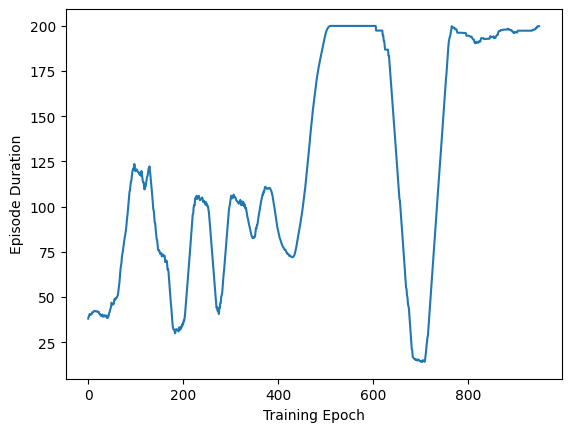

In [84]:
import matplotlib.pyplot as plt

plt.plot(running_mean(score))
plt.xlabel("Training Epoch")
plt.ylabel("Episode Duration")